In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.50, 0.50), std=(0.35, 0.35), cvar(0.30)=(0.07, 0.07) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.30)=(0.53, 0.53) (computed from 10000.0 saved samples)
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999


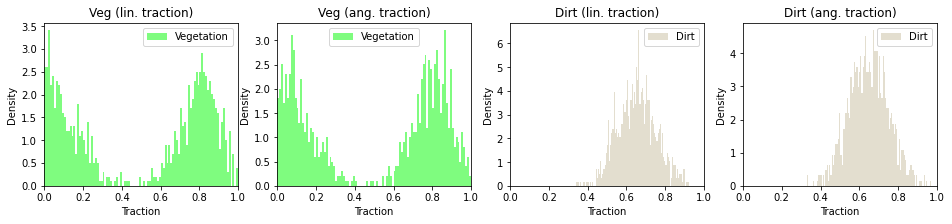

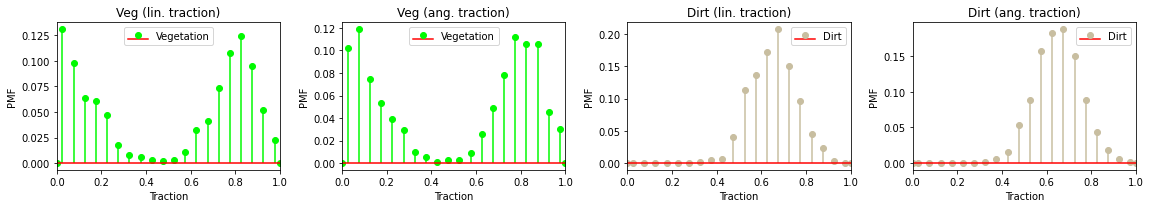

In [2]:
# What percentile of the speed distribution to compute conditional expectation?
cvar_alpha =0.3

pmf_bounds = [0, 1.0]
bush_weights = [0.6, 0.4]
bush_means= [0, 0.8]
bush_std = [0.15, 0.1]
dirt_weights = [1]
dirt_means = [0.65]
dirt_std = [0.1]
# dirt_weights = [1]
# dirt_means = [1]
# dirt_std = [0.001]
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
print(np.sum(b_lin_pmf))
print(np.sum(b_ang_pmf))
print(np.sum(d_lin_pmf))
print(np.sum(d_ang_pmf))



LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

### Methods to pre-generate the random problem setup (start, goal, envs with grass in middle)

10x10 cells, with the center 8x8 cells populated with grass

* Function to run a trial based on specification
* Use the same semantic env for N trials
* Use the same realization for different methods
* Log using panda dataframe and post process

In [ ]:
# Trial function
def trial(semantic_grid, traction_grid, dt, max_speed, max_steps, num_pmf_bins, bin_values, bin_values_bounds, xlimits, ylimits, res, mppi_params):
  # Construct the traction maps
  # lin_tdm = TDM_Numba(max_speed_padding=max_speed)
  # ang_tdm = TDM_Numba(max_speed_padding=max_speed)
  lin_tdm = TDM_Numba(max_speed_padding=max_speed, 
                      use_det_dynamics=mppi_params["use_det_dynamics"],
                      use_nom_dynamics_with_speed_map=mppi_params["use_nom_dynamics_with_speed_map"],
                      use_costmap=mppi_params["use_costmap"]
                      )
  ang_tdm = TDM_Numba(max_speed_padding=max_speed, 
                      use_det_dynamics=mppi_params["use_det_dynamics"],
                      use_nom_dynamics_with_speed_map=mppi_params["use_nom_dynamics_with_speed_map"],
                      use_costmap=mppi_params["use_costmap"])
  lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    # mppi_params["use_det_dynamics"], mppi_params['cvar_alpha'], mppi_params["use_nom_dynamics_with_speed_map"])
                    mppi_params['cvar_alpha'])
  ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                      xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                      mppi_params['cvar_alpha'])

  # Construct the MPPI planner + initialize the GPU variables
  mppi_planner = MPPI_Numba()
  mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)
  mppi_planner.init_device_vars_before_solving()

  # Loop
  xhist = np.zeros((max_steps+1, 3))*np.nan
  uhist = np.zeros((max_steps, 2))*np.nan
  xhist[0] = mppi_params['x0']
  goal_reached=False
  for t in range(max_steps):
    # Solve
    useq = mppi_planner.solve()
    u_curr = useq[0]
    uhist[t] = u_curr

    # Simulate state forward using the sampled map
    lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
    xhist[t+1, 0] = xhist[t, 0] + dt*lt*np.cos(xhist[t, 2])*u_curr[0]
    xhist[t+1, 1] = xhist[t, 1] + dt*lt*np.sin(xhist[t, 2])*u_curr[0]
    xhist[t+1, 2] = xhist[t, 2] + dt*at*u_curr[1]
    
    # Update MPPI state (x0, useq)
    mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

    # Goal check
    if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
      goal_reached = True
      break
  
  # Return trial_info
  trial_logger = dict(
    time_to_goal=(t+1)*dt if goal_reached else np.nan,
    success=goal_reached,
    # xhist=xhist,
    # uhist=uhist
  )
  return trial_logger



def run_trials(cfg, max_speed, max_steps, grid_shape, mud_margin, res, num_pmf_bins, bin_values, bin_values_bounds, default_mppi_params,
               grass_density_list, envs_per_density, trials_per_env, alpha_list, method_list):
  loggers = []
  # For each grass density
  for density_i, grass_density in enumerate(grass_density_list):
    # For each sampled semantic map, pre-generate realizations for evaluation (same more all methods)
    for sem_map_i in range(envs_per_density):
      # # Generate semantic map (only in the center)
      # semantic_grid = np.zeros(grid_shape, dtype=np.int8)
      # rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
      # semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<grass_density] = 1
      
      # Generate semantic map 
      semantic_grid = np.zeros(grid_shape, dtype=np.int8)
      rand_num = np.random.rand(grid_shape[0], grid_shape[1])
      semantic_grid[rand_num<grass_density] = 1
      semantic_grid[:mud_margin, :mud_margin] = 0
      semantic_grid[-mud_margin:, -mud_margin:] = 0


      xlimits = (0,semantic_grid.shape[1]*res)
      ylimits = (0,semantic_grid.shape[0]*res)

      # Pre-generate realizations of the map
      lin_tdm = TDM_Numba(max_speed_padding=max_speed)
      lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG)
      traction_grid_samples = [lin_tdm.sample_grids_true_dist() for _ in range(trials_per_env)]

      # For each method
      for method_i, method in enumerate(method_list):
        # For each alpha
        for alpha_i, alpha in enumerate(alpha_list):
          print(" grass_density={} ({}/{}), sem_map({}/{}), method={}({}/{}), alpha={}({}/{})".format(
              grass_density, density_i+1, len(grass_density_list),
              sem_map_i+1, envs_per_density, 
              method, method_i+1, len(method_list),
              alpha, alpha_i+1, len(alpha_list),
            ))
          t_map_realizations = time.time()
          # For each realized map
          for map_sample_i, traction_grid in enumerate(traction_grid_samples):
            # Update the MPPI parameters
            trial_mppi_params = copy.deepcopy(default_mppi_params)
            trial_mppi_params['cvar_alpha'] = alpha
            if method == 'risk_dyn':
              trial_mppi_params['use_det_dynamics'] = True
              trial_mppi_params['use_nom_dynamics_with_speed_map'] = False
            elif method == 'nom_dyn_risk_cost':
              trial_mppi_params['use_det_dynamics'] = False
              trial_mppi_params['use_nom_dynamics_with_speed_map'] = True
            elif method == 'noisy_dyn':
              trial_mppi_params['use_det_dynamics'] = False
              trial_mppi_params['use_nom_dynamics_with_speed_map'] = False
            else:
              assert False, "Method {} is not expected.".format(method)
            
            # Run trial
            trial_logger = trial(
              semantic_grid, 
              traction_grid, 
              cfg.dt, 
              max_speed, 
              max_steps, 
              num_pmf_bins, 
              bin_values, 
              bin_values_bounds, 
              xlimits, 
              ylimits, 
              res, 
              trial_mppi_params)
            
            # Save other details
            trial_logger['grass_density'] = grass_density
            trial_logger['grass_density_index'] = density_i
            trial_logger['sem_map_index'] = sem_map_i
            trial_logger['method'] = method
            trial_logger['alpha'] = alpha
            trial_logger['map_sample_index'] = map_sample_i

            loggers.append(trial_logger)
          t_elapsed = time.time()-t_map_realizations
          print("{} map realizations took {:.2f}s ({:.2f}s on avg)".format(trials_per_env, t_elapsed, t_elapsed/trials_per_env))

  return pd.DataFrame(loggers)


In [ ]:
# ------------- Map configs ------------
grid_shape = (9, 9)
mud_margin = 1
# grid_shape = (11, 11)
# mud_margin = 2
res = 1.0

num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))

# ------------- Problem configuration ------------
cfg = Config()
u_seq0 = np.zeros((cfg.num_steps, 2), dtype=float)
# x0=np.array([0.5, 0.5, np.pi/4])
# xgoal= np.array([grid_shape[0]-0.5, grid_shape[0]-0.5])
x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
xgoal= np.array([grid_shape[0]-mud_margin/2, grid_shape[0]-mud_margin/2])
max_speed = 3.0
max_steps = 150 # 200

default_mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=cfg.num_steps,
    u_seq0=u_seq0,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.01, # 0.01,
    cvar_alpha=1.0, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0, # 1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([3.0, 2.0]),
    vrange=np.array([0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),

    # Flag for using deterministic dynamics based on cvar
    use_det_dynamics=False,

    # Flag for using nominal rollouts but with risk-speed adjusted time cost
    use_nom_dynamics_with_speed_map=False,

    # Costmap? Keep false since this is for ROS interface
    use_costmap=False
)

# # ------------- Variables to iterate ------------
# # grass_density_list = [0.2, 0.5, 0.8]
# grass_density_list = [0.2, 0.5, 0.8]
# envs_per_density = 10
# trials_per_env = 5
# # alpha_list = np.linspace(1.0, 0.2, 5).tolist()
# alpha_list = [1.0, 0.8, 0.6, 0.4, 0.2]
# method_list = ['noisy_dyn','risk_dyn','nom_dyn_risk_cost']

# ------------- Variables to iterate ------------
# grass_density_list = [0.2, 0.5, 0.8]
grass_density_list = [0.2]
envs_per_density = 2
trials_per_env = 2
# alpha_list = np.linspace(1.0, 0.2, 5).tolist()
alpha_list = [1.0, ]
method_list = ['noisy_dyn','risk_dyn','nom_dyn_risk_cost']

In [ ]:
filename = "mppi_benchmark/exp_log_{}_margin_{}_env_{}_numtrial{}.pickle".format(time.strftime("%Y%m%d-%H%M"),
                                                        mud_margin,
                                                        envs_per_density,
                                                        trials_per_env)

benchmark_start_t = time.time()
logger = run_trials(cfg, max_speed, max_steps, grid_shape, mud_margin, res, num_pmf_bins, bin_values, bin_values_bounds, default_mppi_params,
               grass_density_list, envs_per_density, trials_per_env, alpha_list, method_list)
benchmark_duration = time.time() - benchmark_start_t
print('Benchmark took {:.2f}s'.format(benchmark_duration))

# Save the trials to
with open(filename, 'wb') as fh:
  pickle.dump(dict(
    # Main exp logger
    logger=logger,
    # Other configs
    cfg=cfg, 
    max_speed=max_speed, 
    max_steps=max_steps, 
    grid_shape=grid_shape, 
    mud_margin=mud_margin, 
    res=res, 
    num_pmf_bins=num_pmf_bins, 
    bin_values=bin_values, 
    bin_values_bounds=bin_values_bounds, 
    default_mppi_params=default_mppi_params,
    grass_density_list=grass_density_list, 
    envs_per_density=envs_per_density, 
    trials_per_env=trials_per_env, 
    alpha_list=alpha_list, 
    method_list=method_list,
    # Distributions
    pmf_bounds=pmf_bounds,
    bush_weights=bush_weights,
    bush_means=bush_means,
    bush_std=bush_std,
    dirt_weights=dirt_weights,
    dirt_means=dirt_means,
    dirt_std=dirt_std,
    ), file=fh
  )

print('Save to {}'.format(filename))

In [ ]:
display(logger)

method2rgb = {
  'noisy_dyn': 'r',
  'risk_dyn': 'g',
  'nom_dyn_risk_cost': 'b'
}
method2label = {
  'noisy_dyn': 'Noisy Traction',
  'risk_dyn': r'CVaR($\alpha$) Traction',
  'nom_dyn_risk_cost': 'Risk-Adjusted Cost'
}
sorted_grass_density_list = sorted(grass_density_list)
sorted_alpha_list = sorted(alpha_list)
# Plot success rate vs. alpha for each method
fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=(15, 5))
for density_i, grass_density in enumerate(sorted_grass_density_list):
  if len(sorted_grass_density_list)==1:
    ax=axes
  else:
    ax = axes[density_i]
  for method in method_list:
    success_rate = []
    for alpha in sorted_alpha_list:
      sub_logger = logger[(logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha)]
      success_rate.append(sub_logger['success'].sum()/len(sub_logger))
    success_rate = np.asarray(success_rate)
    ax.plot(sorted_alpha_list, success_rate, '-', color=method2rgb[method], label=method2label[method])
    ax.plot(sorted_alpha_list, success_rate, '.', color=method2rgb[method], markersize=15)
  ax.legend()
  ax.set_ylim([-0.1,1.1])
  if density_i==0:
    ax.set_ylabel('Success Rate')
  ax.set_xlabel(r'$\alpha$')
  ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))

# Plot time-to-goal for successful trials for each alpha
fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=(15, 5))
for density_i, grass_density in enumerate(sorted_grass_density_list):
  if len(sorted_grass_density_list)==1:
    ax=axes
  else:
    ax = axes[density_i]
  for method in method_list:
    t2g = []
    t2g_std = []
    for alpha in sorted_alpha_list:
      sub_logger = logger[logger['success'] & (logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha)]
      if len(sub_logger)>0:
        t2g.append(sub_logger['time_to_goal'].sum()/len(sub_logger))
        t2g_std.append(sub_logger['time_to_goal'].std())
      else:
        t2g.append(np.nan)
        t2g_std.append(np.nan)

        
    t2g = np.asarray(t2g)
    t2g_std = np.asarray(t2g_std)
    ax.plot(sorted_alpha_list, t2g, '-', color=method2rgb[method], label=method2label[method])
    ax.fill_between(sorted_alpha_list, t2g-t2g_std, t2g+t2g_std,
              alpha=0.15, edgecolor='none', facecolor=method2rgb[method])
    ax.plot(sorted_alpha_list, t2g, '.', color=method2rgb[method], markersize=15)
  ax.legend()
  if density_i==0:
    ax.set_ylabel('Time-To-Goal (s)')
  ax.set_xlabel(r'$\alpha$')
  ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))

# Visualize a test scenario

TDM has initialized GPU memory after 0.6300384998321533 s
TDM has initialized GPU memory after 0.0411992073059082 s
MPPI planner has initialized GPU memory after 0.016495466232299805 s


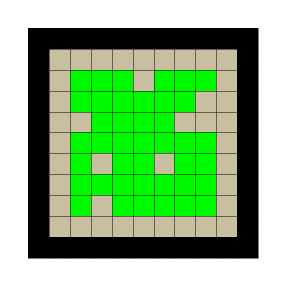

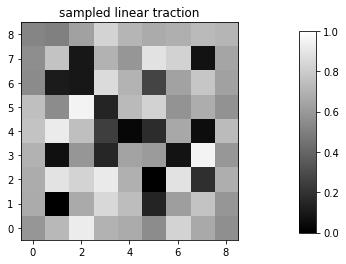

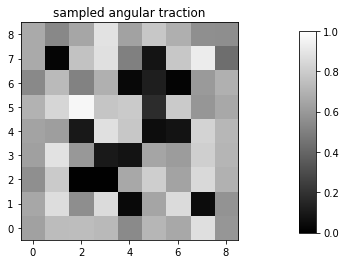

In [3]:
# ------------- Create and visualize the map ------------
# Fixed a sampled environment
grid_shape = (9, 9)
mud_margin = 1
res = 1.0
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
perc_grass = 0.8
# perc_grass = 0.2
semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<perc_grass] = 1


xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))
max_speed = 3.0

use_tdm = True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024,
  num_control_rollouts = 1024,
  max_speed_padding = 5.0,
  # tdm_sample_thread_dim = (16,16),
  num_vis_state_rollouts = 50,
  # max_map_xy_dim =(50, 50),
  # max_map_xy_dim =(15, 15),
  max_map_xy_dim =(11, 11),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)

# ------------- Problem configuration ------------
u_seq0 = np.zeros((cfg.num_steps, 2), dtype=float)
# x0=np.array([0.5, 0.5, 0])
# x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
# xgoal= np.array([3.5, 3.5])
xgoal= np.array([grid_shape[0]-mud_margin/2, grid_shape[0]-mud_margin/2])
# xgoal= np.array([grid_shape[0]-mud_margin, grid_shape[0]-mud_margin])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=cfg.num_steps,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.01,
    cvar_alpha=0.5, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0, # 1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([3.0, 3.0]),
    vrange = np.array([0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

# ------------- Configure the TDM based on whether determinisitc dynamics are used ------------



lin_tdm = TDM_Numba(cfg)
ang_tdm = TDM_Numba(cfg)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    mppi_params['cvar_alpha'])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    mppi_params['cvar_alpha'])


lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))


mppi_planner = MPPI_Numba(cfg)



# Sample a specific map from the distribution that can be used to update the robot state
traction_grid = lin_tdm.sample_grids_true_dist()
fig, ax = plt.subplots()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

fig, ax = plt.subplots()
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()



/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


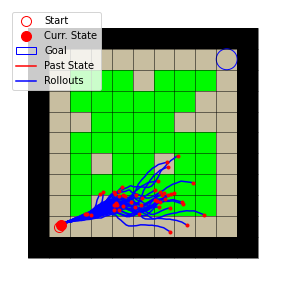

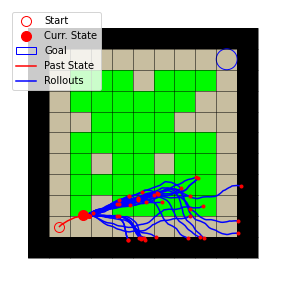

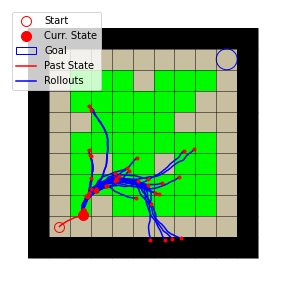

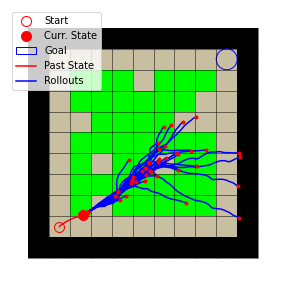

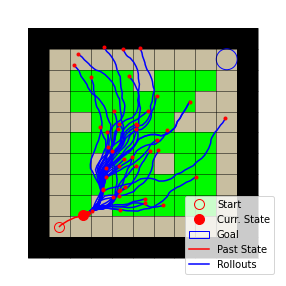

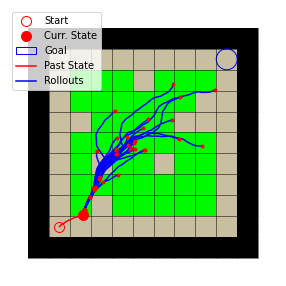

In [4]:

# Construct the MPPI planner + initialize the GPU variables
# mppi_params['cvar_alpha']=0.1
# mppi_params['use_det_dynamics']=True
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)


# Loop
max_steps = 160
# max_steps = 1
# max_steps = 20
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 30
# plot_every_n = 1
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal")
    ax.add_patch(c1)

    # # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    ax.legend()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break



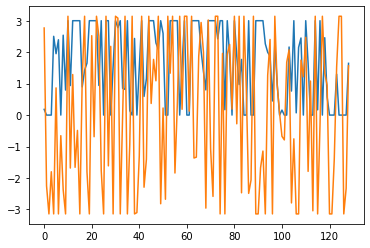

In [13]:
fig, ax = plt.subplots()
ax.plot(uhist[:,0])
ax.plot(uhist[:,1])

In [17]:
lin_grid_batch = lin_tdm.sample_grid_batch_d.copy_to_host()

In [18]:
lin_grid_batch[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  67,  67,  72,  62,  67,  57,  77,  62,  57,   0],
       [  0,  77,  62,  57,  72,  77,  62,  57,  77,  52,   0],
       [  0, 100,  57,  82,  57,  52,  82,  62,  57,  47,   0],
       [  0,  47,  92,  57,  77,  12,  52,  47,  52,  47,   0],
       [  0,  47,  72,  67,  67,  67,  52,  62,  22,  72,   0],
       [  0,  62,  62,  47,  77,  67,  47,  57,  87,  62,   0],
       [  0,  67,  82,  62,  67,  62,   2,  52,  62,  57,   0],
       [  0,  72,  57,  72,  62,  67, 100,  77,  87,  72,   0],
       [  0,  72,  52,  57,  67,  77,  72,  72,  62,  67,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int8)

In [22]:
noise_samples = mppi_planner.noise_samples_d.copy_to_host()

In [27]:
noise_samples[0].mean(axis=0)
noise_samples[0].std(axis=0)

array([2.259141 , 1.8075186], dtype=float32)

0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
